In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.applications.resnet50 import ResNet50
import struct
from struct import unpack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cairocffi as cairo
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [116]:
def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error as e:
                break

def unpack_draw(filename):
    list_drawing = []
    for drawing in unpack_drawings('data/' + filename + '.bin'):
        # do something with the drawing
        list_drawing.append(drawing)
    
    return list_drawing

In [117]:
axe = unpack_draw('axe')

In [118]:
data_axe = pd.DataFrame(data=axe, columns=['key_id', 'countrycode', 'recognized', 'timestamp', 'image'])

In [119]:
data_axe['image_lenth'] = data_axe['image'].apply(lambda x : np.sum(list(map(lambda y: np.sum(list(map(lambda z: len(z) , y))),x))))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c73e8c898>]],
      dtype=object)

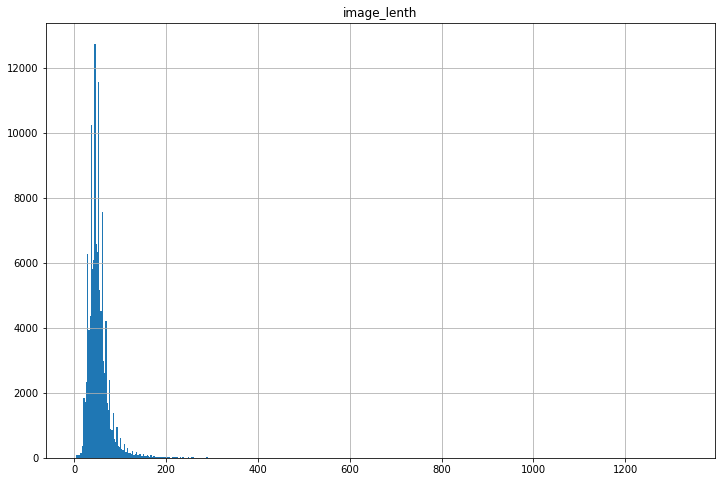

In [120]:
data_axe.hist(bins=500, column='image_lenth', figsize=(12,8))

In [121]:
data_axe['image_lenth'].describe()

count    124122.000000
mean         53.289554
std          28.980302
min           4.000000
25%          38.000000
50%          48.000000
75%          60.000000
max        1330.000000
Name: image_lenth, dtype: float64

In [122]:
data_axe['image'][0][0]

((2, 38, 71, 108, 128, 139), (10, 24, 31, 22, 14, 4))

In [123]:
data_axe['image'].apply(lambda x : max(list(map(lambda y: len(y),x)))).describe()

count    124122.0
mean          2.0
std           0.0
min           2.0
25%           2.0
50%           2.0
75%           2.0
max           2.0
Name: image, dtype: float64

In [124]:
data_axe['image'].apply(lambda x : list(map(lambda y: list(map(lambda z: len(z) , y)),x)))

0                   [[6, 6], [8, 8], [4, 4], [8, 8]]
1                                 [[13, 13], [5, 5]]
2                         [[11, 11], [8, 8], [5, 5]]
3         [[14, 14], [8, 8], [6, 6], [8, 8], [9, 9]]
4                     [[14, 14], [10, 10], [15, 15]]
                             ...                    
124117                            [[21, 21], [4, 4]]
124118                [[11, 11], [10, 10], [15, 15]]
124119                                    [[11, 11]]
124120              [[7, 7], [9, 9], [6, 6], [8, 8]]
124121                              [[3, 3], [9, 9]]
Name: image, Length: 124122, dtype: object

In [128]:
def parse_line(inkarray):
    """Parse an ndjson line and return ink (as np array) and classname."""    
    stroke_lengths = [len(stroke[0]) for stroke in inkarray]
    #print(stroke_lengths)
    total_points = sum(stroke_lengths)
    np_ink = np.zeros((total_points, 3), dtype=np.float32)
    current_t = 0
    for stroke in inkarray:
        for i in [0, 1]:
            np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
        current_t += len(stroke[0])
        np_ink[current_t - 1, 2] = 1  # stroke_end
    # Preprocessing.
    # 1. Size normalization.
    lower = np.min(np_ink[:, 0:2], axis=0)
    upper = np.max(np_ink[:, 0:2], axis=0)
    scale = upper - lower
    scale[scale == 0] = 1
    np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale
    # 2. Compute deltas.
    np_ink[1:, 0:2] -= np_ink[0:-1, 0:2]
    np_ink = np_ink[1:, :]
    return np_ink

In [129]:
def normalize_vector(list_vector):
    new_normalize = []
    for v in list_vector:
        new_normalize.append(parse_line(v))
    return new_normalize

In [130]:
nd_axe = normalize_vector(data_axe['image'])

In [131]:
data_axe['image_normalized'] = nd_axe

In [132]:
data_axe.head(5)

,key_id,countrycode,recognized,timestamp,image,image_lenth,image2,image_normalized
0,5344373355053056,b'KR',1,1490164248,"[((2, 38, 71, 108, 128, 139), (10, 24, 31, 22,...",52,"[((2, 38, 71, 108, 128, 139), (10, 24, 31, 22,...","[[0.20454545, 0.05490196, 0.0], [0.1875, 0.027..."
1,6545061917491200,b'SE',1,1485553794,"[((54, 37, 7, 5, 12, 0, 7, 34, 52, 56, 52, 42,...",36,"[((54, 37, 7, 5, 12, 0, 7, 34, 52, 56, 52, 42,...","[[-0.17525771, -0.06692913, 0.0], [-0.30927834..."
2,4767264018530304,b'US',0,1489097582,"[((146, 145, 154, 154, 197, 196, 189, 191, 178...",48,"[((146, 145, 154, 154, 197, 196, 189, 191, 178...","[[-0.00507617, 0.14960632, 0.0], [0.04568529, ..."
3,5711061690875904,b'DE',1,1490298672,"[((0, 8, 48, 69, 102, 118, 136, 142, 142, 135,...",90,"[((0, 8, 48, 69, 102, 118, 136, 142, 142, 135,...","[[0.033755273, -0.09019607, 0.0], [0.16877638,..."
4,6276192535576576,b'US',1,1485524332,"[((25, 19, 4, 0, 22, 49, 59, 63, 66, 62, 59, 5...",78,"[((25, 19, 4, 0, 22, 49, 59, 63, 66, 62, 59, 5...","[[-0.02714932, 0.21960786, 0.0], [-0.06787331,..."


In [133]:
data_axe['image_length'] = data_axe['image_normalized'].apply(len)

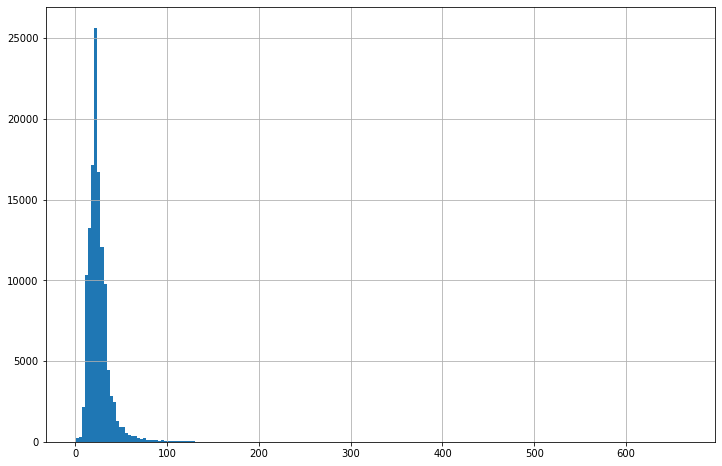

In [134]:
data_axe['image_length'].hist(bins=200, figsize=(12,8))

In [96]:
data_axe['image_length'].describe()

count    124122.000000
mean         25.644777
std          14.490151
min           1.000000
25%          18.000000
50%          23.000000
75%          29.000000
max         664.000000
Name: image_length, dtype: float64

In [97]:
data_axe['image_length'][60000]

46

In [136]:
def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]
    
        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [138]:
raster = vector_to_raster(data_axe['image'])

In [144]:
data_axe['image_net'] = raster

In [152]:
data_axe['image_net'] = data_axe['image_net'].apply(lambda x: x/255)

In [182]:
data_axe['image_net'] = data_axe['image_net'].apply(lambda x: np.reshape(x, (28,28,1)))

In [199]:
def create_classes(name, array):
    index = array.index(name)
    result = [0] * len(array)
    result[index] = 1
    return result

In [205]:
data_axe['image_net'].shape[0]

124122

In [213]:
classes = ['axe']
n_classes = 1
response = create_classes('axe', classes)

In [215]:
data_axe['label'] = pd.Series([response]*data_axe['image_net'].shape[0], index=data_axe.index)

In [197]:
def create_model(height, width, n_classes):
    model = keras.Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(height, width, 1), strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [198]:
model = create_model(28,28, n_classes)

,key_id,countrycode,recognized,timestamp,image,image_lenth,image_normalized,image_length,image_net,label
0,5344373355053056,b'KR',1,1490164248,"[((2, 38, 71, 108, 128, 139), (10, 24, 31, 22,...",52,"[[0.20454545, 0.05490196, 0.0], [0.1875, 0.027...",25,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",[1]
1,6545061917491200,b'SE',1,1485553794,"[((54, 37, 7, 5, 12, 0, 7, 34, 52, 56, 52, 42,...",36,"[[-0.17525771, -0.06692913, 0.0], [-0.30927834...",17,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",[1]
2,4767264018530304,b'US',0,1489097582,"[((146, 145, 154, 154, 197, 196, 189, 191, 178...",48,"[[-0.00507617, 0.14960632, 0.0], [0.04568529, ...",23,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",[1]
3,5711061690875904,b'DE',1,1490298672,"[((0, 8, 48, 69, 102, 118, 136, 142, 142, 135,...",90,"[[0.033755273, -0.09019607, 0.0], [0.16877638,...",44,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",[1]
4,6276192535576576,b'US',1,1485524332,"[((25, 19, 4, 0, 22, 49, 59, 63, 66, 62, 59, 5...",78,"[[-0.02714932, 0.21960786, 0.0], [-0.06787331,...",38,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",[1]
...,...,...,...,...,...,...,...,...,...,...
124117,6159496642560000,b'US',1,1489597837,"[((3, 10, 29, 45, 51, 65, 75, 77, 42, 29, 15, ...",50,"[[0.06422018, 0.27058822, 0.0], [0.17431194, 0...",24,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",[1]
124118,5149341360586752,b'US',1,1485895448,"[((17, 17, 29, 29, 33, 89, 95, 95, 77, 47, 35)...",72,"[[0.0, -0.12156862, 0.0], [0.12631579, -0.4666...",35,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",[1]
124119,6390876014116864,b'US',1,1485783642,"[((0, 35, 112, 146, 209, 223, 230, 249, 255, 2...",22,"[[0.13725491, -0.13402063, 0.0], [0.30196077, ...",10,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",[1]
124120,4710517769764864,b'US',1,1488997265,"[((14, 1, 2, 17, 34, 46, 62), (2, 43, 84, 117,...",60,"[[-0.11304348, 0.16078432, 0.0], [0.008695652,...",29,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",[1]
